# Homework 1 Section B: Named Entity Recognition (NER) with HMMs

### Milestone Submission Due: February 12, 2025 (11:59PM)
### Project Submission Due: February 21, 2025 (11:59PM)

## **Logistics**

### Notes: 
  
- You will **NOT** be submitting this .ipynb file. Please refer to the submission instructions in both the hw1 pdf shared with you and at the end of this notebook.
- Please complete the written questions in the same pdf document where you attempt Section A of the homework.
- Do **NOT** add, remove, or modify any imports across python source files. If you have any concerns regarding missing imports, please let course staff know through EdStem before attempting to change anything.
- Do **NOT** change any of the function headers and/or specs! The input(s) and output must perfectly match the specs, or else your implementation for any function with changed specs will most likely fail! (for e.g. do not shuffle your data when generating the output.txt file! )
- If you decide to create local helper functions, your code must have docstrings/comments documenting the meaning of parameters and important parameter-like variables.
- We are recommending python version 3.9+. This is due to compatibility issues with the external dependencies.


### Tips:
- Pair program the more intensive parts of this assignment! You'll thank yourselves later for the amount of trouble this helps you avoid.
- We recommend you start this assignment early and continue incrementally adding onto it!

## Part 0: Environment setup

**IMPORTANT:** Read the following file: `vscode-setup.md` to setup your environment for development including setting up VSCode, adding Python extensions, creating virtual environments, and installing dependencies.

In [5]:
### AUTORELOAD EXTENSION -- DO NOT MODIFY ###
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
### IMPORTS -- DO NOT MODIFY ###
import json
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from helpers import apply_smoothing, handle_unknown_words
from models import HMM
from viterbi import viterbi
from validation import evaluate_model, mean_f1, format_output_labels
from data_exploration import unzip_data, read_json, stringify_labeled_doc, validate_ner_sequence

## Part 1: Data Exploration

### Loading the Data

The data is stored in a zip file. You can use the following provided function to
load the data and preprocess it. Under the hood, this is unzipping the data and reading each of
the provided json data files into Python dictionaries. It then further formats the data such that
we can accurately train our model from it.

In [7]:
data_zip_path = "./dataset.zip"
dest_path = "dataset"

unzip_data(data_zip_path, dest_path) # unzips the data into current directory

training_data = read_json(os.path.join(dest_path, "train.json"))
validation_data = read_json(os.path.join(dest_path, "val.json"))
test_data = read_json(os.path.join(dest_path, "test.json"))

training_data['text'] = [sen[:-1] for sen in training_data['text']]
validation_data['text'] = [sen[:-1] for sen in validation_data['text']]
test_data['text'] = [sen[:-1] for sen in test_data['text']]

training_data['NER'] = [sen[:-1] for sen in training_data['NER']]
validation_data['NER'] = [sen[:-1] for sen in validation_data['NER']]

training_data['index'] = [sen[:-1] for sen in training_data['index']]
validation_data['index'] = [sen[:-1] for sen in validation_data['index']]
test_data['index'] = [sen[:-1] for sen in test_data['index']]

### Looking at the data

Since your data files can be large and unwieldy, you can explore the data by
writing code. Check out the data format by looking at at keys, and some of the
values in the data. You can use the following code to get started:

In [8]:
print(training_data.keys())
print(validation_data.keys())
print(test_data.keys())
print("test data text", test_data['text'])

dict_keys(['index', 'text', 'NER'])
dict_keys(['index', 'text', 'NER'])
dict_keys(['index', 'text'])
test data text [['The', 'Tigers', 'also', 'signed', 'free', 'agent', 'catcher', 'Brayan', 'Peña', 'to', 'a', 'one-year', 'contract'], ['He', 'was', 'appointed', 'first', 'team', 'manager', 'at', 'non-league', 'club', 'A.F.C.', 'Fylde', 'in', 'December', '2009', 'having', 'been', 'assisting', 'as', 'first', 'team', 'coach', 'for', 'three', 'months', 'prior', 'to', 'this'], ['This', 'was', 'very', 'unlike', 'the', 'narrow', 'alleys', ',', 'cobbled', 'streets', ',', 'and', 'dead-ends', 'that', 'were', 'characteristic', 'of', 'Ottoman', 'cities', 'at', 'the', 'time'], ['She', 'first', 'recorded', 'for', 'Columbia', 'in', '1925', ',', 'achieving', 'a', 'hit', 'with', '"', 'Dinah', '"'], ['In', 'his', 'speech', ',', 'he', 'asked', 'for', 'humanitarian', 'aid', 'for', 'the', 'people', 'of', 'Afghanistan'], ['The', 'Upper', 'Harz', 'dialect', 'was', 'used', 'only', 'in', 'a', 'few', 'places'], 

Notice the test data does not have any labels. This is because you will need to
predict them using your models!

To get a sense of what your data looks like, check out some samples. Implement
the `stringify_labeled_doc` function in `data_exploration.py`, and use it to print
out some samples of the data.

In [9]:
random_index = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index]
ner = training_data['NER'][random_index]
s = stringify_labeled_doc(text, ner)
print(s)

Along the- wide breakthrough, the [ORG Red Army] concentrated 3,000 guns and mortars


#### Q1.1: Using the `stringify_labeled_doc` function you implemented, print 5 documents (sentences) from the training data which have at least 4 distinct tags (including 'O'). What do you notice? 

In [10]:
# YOUR CODE HERE
#Want: 5 sentences with 4 distinct tags 
#First, get the indicies of these such sentences! 
indices = []
n = len(training_data['NER'])
for i in range(n):
    ner = training_data['NER'][i]
    distinct_tags = set()
    #Get distinct tags for each ner
    for tag in ner:
        if tag == "O":
            distinct_tags.add(tag)
        else:
            distinct_tags.add(tag[2:])
    #print("distinct tags", distinct_tags)
    if len(distinct_tags) >= 4:
        #print("4 uniqute")
        indices.append(i)
        if len(indices) == 5:
            break 
            
#Print with stringify_labeled_doc
#print(indices)

for ind in indices:
    text = training_data['text'][ind]
    ner = training_data['NER'][ind]
    s = stringify_labeled_doc(text, ner)
    print(s)

Cutting the skin into strips, she laid out her claim and founded an empire that would become, through the [MISC Punic Wars], the only existential threat to [LOC Rome] until the coming of the [PER Vandals] several centuries later
The [LOC Chatham] oystercatcher is endemic to the [LOC Chatham Islands] of [LOC New Zealand] but is listed as endangered by the [ORG IUCN], while both the [MISC African] and [MISC Eurasian] oystercatchers are considered near threatened
He then moved to the [ORG Deutsche Eishockey Liga] in [LOC Germany] for [ORG ERC Ingolstadt] and then to the [MISC Elitserien] in [LOC Sweden] for [ORG Leksands IF]
In his keynote address at the 2015 [MISC South by Southwest] music festival, he blamed [LOC Los Angeles] 's explosion of gang violence in the 1980 s on the economic policies of [PER Ronald Reagan], and insinuated that his administration shipped guns and drugs into the area
Further mention of events in [LOC Kent] occurs in the late sixth century history of the [MISC Fr

### Validating the data

This data looks okay, _right?_ ... _right?_ The reality is that language data is
super messy. One option would be to look through every example by hand, but this
is impractical. Another option would be to write a program that could check if
each example is correct, but if you could do that, you wouldn't need to write
the program to do NER tagging in the first place! However, there is a middle
ground. If you had a programatic way to check the validity of the data, you
could catch some of these issues. Let's try to do that.

#### Q1.2: Implement the `validate_ner_sequence` function in `data_exploration.py` Are there any documents in the training data which have invalid labelings? If so, how many are there?

Hint: Think about what makes a valid sequence of labels under the BIO tagging scheme.

### Data Statistics

In order to look at the data in a different way, you can visualize some of its characteristics. Take the example
below, which shows the distribution of the number of tokens per document in the training data. You can use the following code to get started:

In [11]:

invalid_count = sum(not validate_ner_sequence(doc_tags) for doc_tags in training_data)
print("Number of documents with invalid labelings:", invalid_count)


Number of documents with invalid labelings: 3


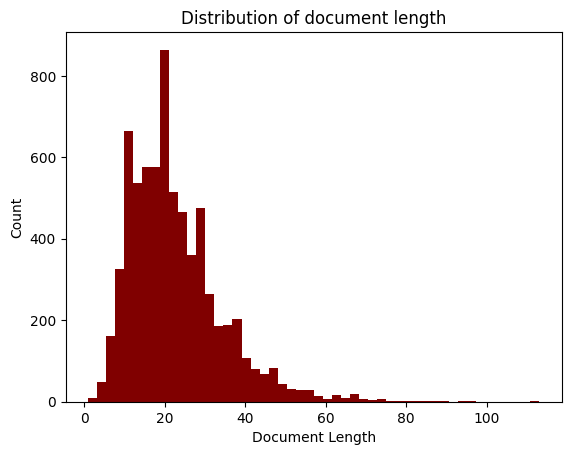

In [12]:
doc_lengths = [len(doc) for doc in training_data["text"]]

def plot_histogram(data, title, xlabel, ylabel, bins=50):
  """
  Plots a histogram of the data.

  Input:
    data: List[Int], representing the data to be plotted
    title: String, representing the title of the plot
    x_label: String, representing the x-axis label
    y_label: String, representing the y-axis label
    i: Int, representing the figure number
  Output:
    None
  """
  plt.hist(data, bins=bins, color="maroon")
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

plot_histogram(
		doc_lengths,
		"Distribution of document length",
		"Document Length",
		"Count",
)

#### Q1.3: Provide a bar graph giving the token level distribution of NER tags, (O included): e.g. 10% of tokens are B-ORG, 20% of tokens are I-ORG, etc. What do you notice about this distribution? Is this what you might expect? What difficulties might this cause for your models?

# Response to 1.3
I noticed that a large majority of NER tags are O, which is what I would expect. It may be difficult for our model to predict the rarer entity tags because the occurrence of O is high. 

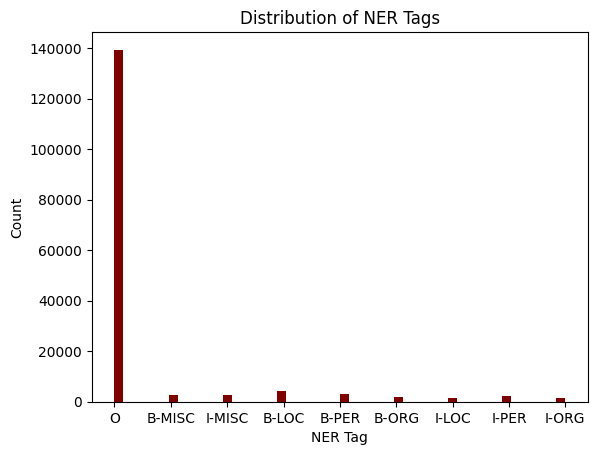

In [13]:
# YOUR CODE HERE
# Want token level distribution of NER tags (O included)
tags = [tag for ner in training_data["NER"] for tag in ner]

plot_histogram(tags, "Distribution of NER Tags", "NER Tag", "Count",)

#### Q1.4: It seems to be that entity tokens are uppercase. Is this correct? Plot a 2x2 matrix displaying the counts, where one dimension represents whether a token is uppercase and the other dimension indicates whether the token is part of an entity. What do you notice about this distribution? Is this what you might expect?

[[18308, 1104], [8054, 131371]]


Text(0, 0.5, 'Entity Status')

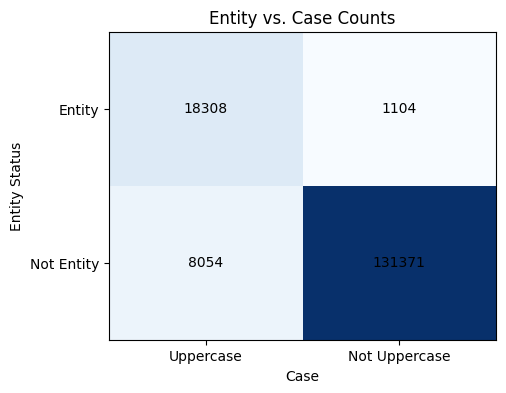

In [14]:
# YOUR CODE HERE

#Is Entity? by Is Uppercase? Matrix

#Count each of these entries
ent_up = 0
not_ent_up = 0
ent_not_up = 0
not_ent_not_up = 0

all_tokens = [token for tokens in training_data["text"] for token in tokens]
all_tags   = [tag for tags in training_data["NER"] for tag in tags]

n = len(all_tokens)
for i in range(n):
    word = all_tokens[i]
    tag = all_tags[i]
    #print(word, tag)
    if tag != "O" and len(word)>0 and word[0].isupper():
        ent_up +=1
    elif (tag == "O") and len(word)> 0 and (word[0].isupper()):
        not_ent_up +=1
    elif (tag != "O") and len(word)>0 and (not word[0].isupper()):
        ent_not_up +=1
    elif (tag == "O") and len(word)> 0 and (not word[0].isupper()):
        not_ent_not_up +=1

print( [[ent_up, ent_not_up], [not_ent_up, not_ent_not_up]])


matrix = [
    [ent_up,        ent_not_up],
    [not_ent_up,    not_ent_not_up]
]

# Convert to numpy array (not strictly necessary, but often convenient).
counts = np.array(matrix)

plt.figure(figsize=(5, 4))
plt.imshow(counts, cmap='Blues', aspect='auto')

# We'll label rows/columns based on how we arranged the matrix:
#   - Rows: [Entity, Not Entity]
#   - Cols: [Uppercase, Not Uppercase]
row_labels = ["Entity", "Not Entity"]
col_labels = ["Uppercase", "Not Uppercase"]

# Add tick marks
plt.xticks([0, 1], col_labels)
plt.yticks([0, 1], row_labels)

# Annotate each cell with its count
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        plt.text(j, i, str(counts[i, j]),
                 ha="center", va="center", color="black")

plt.title("Entity vs. Case Counts")
plt.xlabel("Case")
plt.ylabel("Entity Status")


# Response to 1.4
18308 words are both uppercase and part of an entity, and 1104 words are both lowercase and part of an entity. There lesss lowercase + entity words than uppdercase + entity words, which I expected. Also there are 8054 words in the corpus that are uppercase but not part of an entity (likely words such as "I", "The", etc). The majority of words being lowercase + not entity is expected.

#### Q1.5: Provide a list of the 10 tokens which are most frequently tagged as part of a named entity. What do you notice about this distribution? What difficulties might this cause for your models?

For examples if
- tokens = ["Cornell", "University", "is", "a", "university", "in", "Ithaca", ",", "New", "York"]
- tags   = ["B-ORG", "I-ORG", "O", "O", "O", "O", "B-LOC", "O", "B-LOC", "I-LOC"]

In this example, there are 3 named entities:
- ["Cornell University", "Ithaca", "New York"].

However, you are only interested in tokens which are tagged as part of named entities, which would be ["Cornell", "University, "Ithaca", "New", "York"].

In [15]:
# YOUR CODE HERE
# Top 10 (in count) for words with an entity tag
entity_word_counter = {}
all_tokens = [token for tokens in training_data["text"] for token in tokens]
all_tags   = [tag for tags in training_data["NER"] for tag in tags]

n = len(all_tokens)
for i in range(n):
    word = all_tokens[i]
    tag = all_tags[i]
    #print(word, tag)
    if tag != "O":
        entity_word_counter[word] = entity_word_counter.get(word, 0) + 1


#Sort the hashmap 
sorted_counter = dict(sorted(entity_word_counter.items(), key=lambda item: item[1], reverse= True))

print(list(sorted_counter.items())[:10])
top_ten = list(sorted_counter.keys())[:10]

print("The top ten tokens most frequently tagged as named entity are ",top_ten) 

[('of', 286), ('The', 126), ('the', 121), ('New', 86), ('World', 85), ('United', 85), ('War', 74), ('States', 70), ('John', 63), ('and', 60)]
The top ten tokens most frequently tagged as named entity are  ['of', 'The', 'the', 'New', 'World', 'United', 'War', 'States', 'John', 'and']


#### Q1.6: Provide a scatter plot mapping the length of a document to the number of named entities in that document. Describe what the plot looks like, and what it might mean about the relationship between named entities and document length.

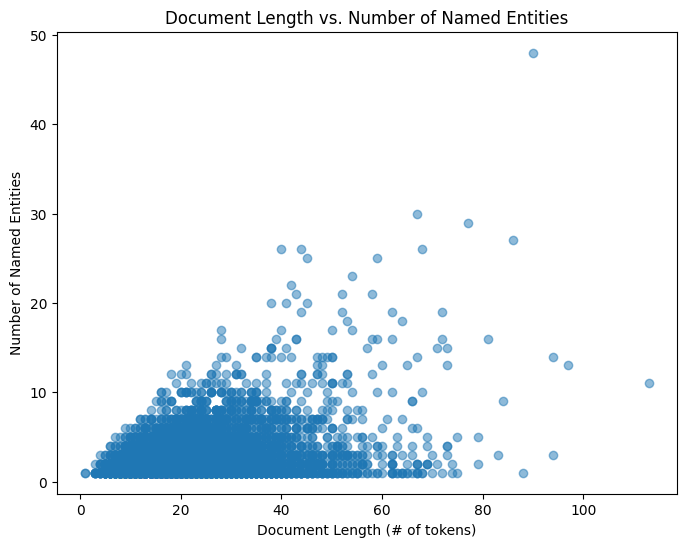

In [16]:
# YOUR CODE HERE
# Scatter Plot: Length of Doc (Total Number of Tokens) Vs. Number of Named Entities in Doc
doc_lengths = [len(doc) for doc in training_data["text"]]
num_entities = []

n = len(training_data["text"])
for i in range(n):
    ner = training_data["NER"][i]
    m = len(ner)
    ent_count = 0
    for j in range(m):
        tag = ner[j]
        if tag != "O":
            ent_count +=1
    num_entities.append(ent_count)

plt.figure(figsize=(8,6))
plt.scatter(doc_lengths, num_entities, alpha=0.5)
plt.xlabel("Document Length (# of tokens)")
plt.ylabel("Number of Named Entities")
plt.title("Document Length vs. Number of Named Entities")
plt.show()

According to the scatter plot, the relationship between Document Length and Number of Named Entities appears to have a very, very weak positive association: This means that while "generally" longer documents associate with more named entities, it's not a strict conclusion. Also, a large cluster of our data is part of shorter document lengths + lower number of named entities.

#### Q1.7: Make a convincing arugment around a novel insight about the data. In only a few sentences, argue why this insight is important in understanding the data for this task, and support your answer with relevant graphs or statistics.

# Response to 1.7

In our code below, we found that only about 15.02% of entity spans appear at least twice in the training data. This is a novel insight because it can challenge the assumption that entity repetition is common enough to be highly leveraged by the model. The percentage reveals that the majority of entities are actually relatively unique within a document, so relying on counts for tagging may be not super effective. One way to address this is to add smoothing or perhaps increasing our n-gram assumption behind this model to account for unseen instances and account for more context.

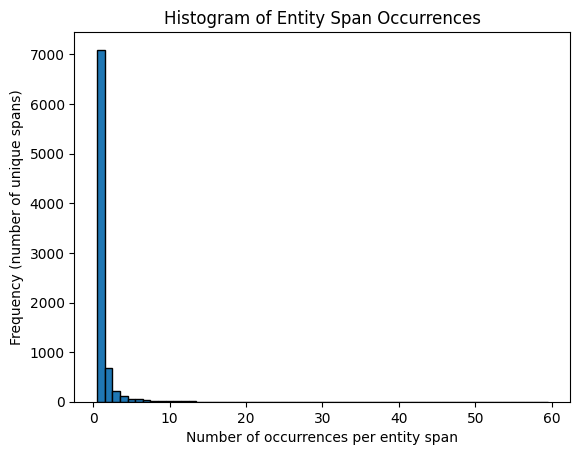

Percentage of entity spans occurring at least twice: 15.02%


In [17]:
from collections import Counter

def get_entity_spans(tokens, ner_tags):
    """
    Get entity spans from a sentence.
    Returns a list of entity spans as tuples (span_text, tag).
    """
    spans = []
    current_span = []
    current_tag = None
    for i in range(len(tokens)):
        token = tokens[i]
        tag = ner_tags[i]
        if tag.startswith("B-"):
            if current_span:
                spans.append((" ".join(current_span), current_tag))
            current_span = [token]
            current_tag = tag[2:]
        elif tag.startswith("I-") and current_tag == tag[2:]:
            current_span.append(token)
        else:
            if current_span:
                spans.append((" ".join(current_span), current_tag))
                current_span = []
                current_tag = None
    if current_span:
        spans.append((" ".join(current_span), current_tag))
    return spans

# get all spans
all_spans = []
for i in range(len(training_data["text"])):
    tokens = training_data["text"][i]
    ner_tags = training_data["NER"][i]
    spans = get_entity_spans(tokens, ner_tags)
    all_spans.extend(spans)

# count how many times each (entity span, tag) pair occurs
span_counter = Counter(all_spans)

# plot histogram: x-axis = number of occurrences, y-axis = count of unique spans with that occurrence
counts = list(span_counter.values())
max_count = max(counts) if counts else 1
plt.hist(counts, bins=range(1, max_count+2), align="left", edgecolor='black')
plt.xlabel("Number of occurrences per entity span")
plt.ylabel("Frequency (number of unique spans)")
plt.title("Histogram of Entity Span Occurrences")
plt.show()

# Calculate percentage of entity spans occurring at least twice
num_repeated = sum(1 for count in counts if count >= 2)
total_spans = len(counts)
percentage_repeated = (num_repeated / total_spans * 100) if total_spans > 0 else 0
print("Percentage of entity spans occurring at least twice: {:.2f}%".format(percentage_repeated))


## Part 2: Hidden Markov Model
In this part of the assignment, you will:
1. Implement code for counting and smoothing of labels and words, as well as unknown word handing, as necessary to support the Viterbi algorithm.
2. Build a Hidden Markov Model in accordance with the starter code that has been provided in `models.py`.
3. Implement the **Viterbi algorithm**, that can be used to infer token-level labels (identifying the appropriate named entity) for an input document. This process is commonly referred to as **decoding**. Bigram-based Viterbi is $ \mathcal{O}(sm^2)$ where *s* is the length of the sentence and *m* is the number of tags. Your implementation should have similar efficiency. 

### Unknown Word Handling
---
Handling unknown words is essential for improving the robustness of your sequence tagging model. When your model encounters words that were not present in the training data, it might struggle to make accurate predictions.

In this section, you will complete `handle_unknown_words(t, documents)` function in `helpers.py` The unknown word handling function replaces infrequently occurring words in the text data with a special "\<unk\>" token. This ensures that words with low occurrence are not treated as unique and distinct, allowing the model to recognize them as a common unknown category. By doing so, the method helps the model maintain consistent performance when dealing with unfamiliar or rare words, enhancing its ability to handle unseen data effectively.

Detailed specs about expected inputs and outputs are outlined in `helpers.py`. It injests the tokenized documents of a corpus (e.g. the training_data["text"] from above) and returns a tokenized document corpus with infrequent words replaced by "\<unk\>", as well as the resulting vocab.

After you complete the function, you may run the following basic test case. Passing this test does NOT guarantee correctness and it is a good idea to write some tests of your own.

In [18]:
t = 0.3  #see helpers.py for information about this parameter means
documents = [["good", "morning"], ["is", "good", "morning"], ["hello"]]
expected_new_documents = [["good", "morning"], ["is", "good", "morning"], ["<unk>"]]  
expected_vocab = ["good", "morning", "is", "<unk>"]  
new_documents, vocab = handle_unknown_words(t, documents)

print(expected_new_documents)
print(new_documents)

assert expected_new_documents == new_documents
assert sorted(expected_vocab) == sorted(vocab)

[['good', 'morning'], ['is', 'good', 'morning'], ['<unk>']]
[['good', 'morning'], ['is', 'good', 'morning'], ['<unk>']]


### Smoothing
---
Smoothing makes our sequence tagging model more resilient to unexpected words and rare patterns, improving its ability to predict accurately on unseen data.

In this section, you will complete `apply_smoothing(k, observation_counts, unique_obs)` function in `helpers.py` file. The function implements an add-k smoothing. It adds a constant value (k) to each count before calculating probabilities, ensuring that no count is zero and that probabilities are never zero. While there are more advanced smoothing techniques, add-k smoothing provides a good starting point for handling the challenges of sparse data in probabilistic modeling.

For example, given an unsmoothed frequency count
```
unsmoothed_counts = {
    ('PER', 'John'): 3,
    ('PER', 'Google'): 0,
    ('PER', 'California'): 0,
    ('PER', 'works'): 0,
    ('PER', 'at'): 0,
    ('ORG', 'Google'): 2,
    ('ORG', 'John'): 0,
    ('ORG', 'California'): 0,
    ('ORG', 'works'): 0,
    ('ORG', 'at'): 0,
    ('LOC', 'Google'): 0,
    ('LOC', 'John'): 0,
    ('LOC', 'California'): 1,
    ('LOC', 'works'): 0,
    ('LOC', 'at'): 0,
    ('O', 'Google'): 0,
    ('O', 'John'): 0,
    ('O', 'California'): 0,
    ('O', 'works'): 4,
    ('O', 'at'): 5,
}
```
the smoothed add-1 frequency count should be
```
smoothed_counts = {
    ('PER', 'John'): 3 + 1,
    ('PER', 'Google'): 0 + 1,
    ('PER', 'California'): 0 + 1,
    ('PER', 'works'): 0 + 1,
    ('PER', 'at'): 0 + 1,
    ('ORG', 'Google'): 2 + 1,
    ('ORG', 'John'): 0 + 1,
    ('ORG', 'California'): 0 + 1,
    ('ORG', 'works'): 0 + 1,
    ('ORG', 'at'): 0 + 1,
    ...same for 'LOC' and 'O'
}
```
and the smoothed add-1 probability would be
```
smoothed_prob = {
    ('PER', 'John'): (3 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'Google'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'California'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'works'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'at'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('ORG', 'Google'): (2 + 1) / (2 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ...
}
```
Note when you call `apply_smoothing` function later in the HMM, the input `observation_counts` should contain counts for all possible `(curr NER tag, next NER tag)` pairs for transition matrix and `(NER tag, word)` pairs for emission matrix. i.e. if a `(NER tag, word)` doesn't appear in the training data, you should still include it as `observation_counts[(NER tag, word)]=0`.

After you complete the function, you may run the following basic test case. Passing this test does NOT guarantee correctness and it is a good idea to write some tests of your own. <br>

**NOTE: This example uses entity tags, but you should be using BIO tags in the assignment (ex: B-ORG, I-ORG, B-PER, I-PER, B-LOC, I-LOC, B-MISC, I-MISC, O).**

**In your implementation, you should store values in the log space**

In [19]:
k = 1
test_counts = {
    ('PER', 'John'): 3,
    ('PER', 'Google'): 0,
    ('PER', 'California'): 0,
    ('PER', 'works'): 0,
    ('PER', 'at'): 0,
    ('ORG', 'Google'): 2,
    ('ORG', 'John'): 0,
    ('ORG', 'California'): 0,
    ('ORG', 'works'): 0,
    ('ORG', 'at'): 0,
    ('LOC', 'Google'): 0,
    ('LOC', 'John'): 0,
    ('LOC', 'California'): 1,
    ('LOC', 'works'): 0,
    ('LOC', 'at'): 0,
    ('O', 'Google'): 0,
    ('O', 'John'): 0,
    ('O', 'California'): 0,
    ('O', 'works'): 4,
    ('O', 'at'): 5,
}

expected_log_smoothed_probs = {
    ('PER', 'John'): np.log(4/8),
    ('PER', 'Google'): np.log(1/8),
    ('PER', 'California'): np.log(1/8),
    ('PER', 'works'): np.log(1/8),
    ('PER', 'at'): np.log(1/8),
    ('ORG', 'Google'): np.log(3/7),
    ('ORG', 'John'): np.log(1/7),
    ('ORG', 'California'): np.log(1/7),
    ('ORG', 'works'): np.log(1/7),
    ('ORG', 'at'): np.log(1/7),
    ('LOC', 'Google'): np.log(1/6),
    ('LOC', 'John'): np.log(1/6),
    ('LOC', 'California'): np.log(2/6),
    ('LOC', 'works'): np.log(1/6),
    ('LOC', 'at'): np.log(1/6),
    ('O', 'Google'): np.log(1/14),
    ('O', 'John'): np.log(1/14),
    ('O', 'California'): np.log(1/14),
    ('O', 'works'): np.log(5/14),
    ('O', 'at'): np.log(6/14),
}

vocab = ['John', 'Google', 'California', 'works', 'at']

log_smoothed_probs = apply_smoothing(k, test_counts, vocab)

assert len(expected_log_smoothed_probs) == len(log_smoothed_probs)
for key in test_counts:
    np.testing.assert_almost_equal(expected_log_smoothed_probs[key], log_smoothed_probs[key])

### Milestone submission

You can make a milestone submission here. You need to submit your `helpers.py' file to hw1-milestone. The output of this function is expected to be a Python dictionary, where the keys are state-observation tuples, and the corresponding values are the log smoothed observation probabilities. We will not check if the values are exactly correct for the milestone submission, but we will run a basic sanity test to check that your returned dictionary does not contain any 0 probability (or -inf log probability values). 

In particular, we will check to ensure that all (NER tag, word) pairs with 0 observation counts have been included and assigned log smoothed probabilities.

### **HMM Class Implementation**
---
In this section, you will be implementing the HMM class using the following properties.


- **documents**: dataset of sentences to train model
- **labels**: NER labels corresponding the sentences to train model
- **vocab**: dataset vocabulary
- **all_tags**: all possible NER tags
- **k_t**: add-k parameter to smooth transition probabilities
- **k_e**: add-k parameter to smooth emission probabilities
- **k_s**: add-k parameter to smooth starting state probabilities
- **smoothing_func**: smoothing function to smooth state-observation probabilities


In the `model.py` file, complete following methods under the HMM class:
1. `build_transition_matrix()`: returns the transition probabilities as a dictionary, mapping all possible (tag, tag) tuple pairs to their corresponding smoothed log probabilities. See function declaration for more details.

2. `build_emission_matrix()`:
    returns the emission probabilities as a dictionary, mapping all possible
    (tag, token) tuple pairs to their corresponding smoothed log probabilities. See function declaration for more details.
    
3. `get_start_state_probs()`:
    returns the starting state probabilities as a dictionary, mapping all possible
    tags to their corresponding smoothed log probabilities. See function declaration for more details.
      
4. `get_tag_likelihood(predicted_tag, previous_tag, document, i)`
     returns the tag likelihood used by the Viterbi algorithm for the log probability of a given
    predicted_tag conditioned on the previous_tag and document at index i. See function declaration for more details.

To help you check your implementation, we give you a toy example with only 3 tags: ["B-PER", "O", "B-LOC"]. You may run this following basic test case to test your implementation of build_transition_matrix() and build_emission_matrix(). Passing this test does NOT guarantee correctness and it is a good idea to write some tests of your own. 

In [20]:
toy_hmm_documents = [['Alice', 'and', 'Bob', 'walk', 'in', 'Paris'], ['Bob', 'and', 'Alice', 'walk', 'in', 'Paris']]
toy_hmm_vocab = list(set([item for sublist in toy_hmm_documents for item in sublist]))
toy_hmm_ner_tags = [['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC'], ['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC']]
print(toy_hmm_ner_tags)
print(toy_hmm_vocab)
test_hmm_all_tags = list(set([item for sublist in toy_hmm_ner_tags for item in sublist]))
test_hmm = HMM(toy_hmm_documents, toy_hmm_ner_tags, toy_hmm_vocab, test_hmm_all_tags, 
          k_t=1, k_e=1, k_s=1, smoothing_func=apply_smoothing)
true_emission_matrix = {
    ('B-LOC', 'Bob'): np.log(1/8), 
    ('B-LOC', 'Alice'): np.log(1/8), 
    ('B-LOC', 'in'): np.log(1/8), 
    ('B-LOC', 'and'): np.log(1/8), 
    ('B-LOC', 'Paris'): np.log(3/8), 
    ('B-LOC', 'walk'): np.log(1/8), 
    ('B-PER', 'Bob'): np.log(3/10), 
    ('B-PER', 'Alice'): np.log(3/10), 
    ('B-PER', 'in'): np.log(1/10), 
    ('B-PER', 'and'): np.log(1/10), 
    ('B-PER', 'Paris'): np.log(1/10), 
    ('B-PER', 'walk'): np.log(1/10), 
    ('O', 'Bob'): np.log(1/12), 
    ('O', 'Alice'): np.log(1/12), 
    ('O', 'in'): np.log(3/12), 
    ('O', 'and'): np.log(3/12), 
    ('O', 'Paris'): np.log(1/12), 
    ('O', 'walk'): np.log(3/12)
}

true_transition_matrix = {
    ('B-LOC', 'B-LOC'): np.log(1/6), 
    ('B-LOC', 'B-PER'): np.log(1/6), 
    ('B-LOC', 'O'): np.log(1/6), 
    ('B-LOC', 'qf'): np.log(3/6), 
    ('B-PER', 'B-LOC'): np.log(1/8), 
    ('B-PER', 'B-PER'): np.log(1/8), 
    ('B-PER', 'O'): np.log(5/8), 
    ('B-PER', 'qf'): np.log(1/8), 
    ('O', 'B-LOC'): np.log(3/10), 
    ('O', 'B-PER'): np.log(3/10), 
    ('O', 'O'): np.log(3/10), 
    ('O', 'qf'): np.log(1/10)
}

for key in true_emission_matrix:
    np.testing.assert_almost_equal(true_emission_matrix[key], test_hmm.emission_matrix[key])
for key in true_transition_matrix:
    np.testing.assert_almost_equal(true_transition_matrix[key], test_hmm.transition_matrix[key])

[['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC'], ['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC']]
['and', 'walk', 'in', 'Alice', 'Paris', 'Bob']
['and', 'walk', 'in', 'Alice', 'Paris', 'Bob'] dict_keys([('B-PER', 'and'), ('B-PER', 'walk'), ('B-PER', 'in'), ('B-PER', 'Alice'), ('B-PER', 'Paris'), ('B-PER', 'Bob'), ('B-LOC', 'and'), ('B-LOC', 'walk'), ('B-LOC', 'in'), ('B-LOC', 'Alice'), ('B-LOC', 'Paris'), ('B-LOC', 'Bob'), ('O', 'and'), ('O', 'walk'), ('O', 'in'), ('O', 'Alice'), ('O', 'Paris'), ('O', 'Bob')]) emission count vocab vs keys
['B-PER', 'B-LOC', 'O'] all tags
ner pair counts {('B-PER', 'B-PER'): 0, ('B-PER', 'B-LOC'): 0, ('B-PER', 'O'): 4, ('B-PER', 'qf'): 0, ('B-LOC', 'B-PER'): 0, ('B-LOC', 'B-LOC'): 0, ('B-LOC', 'O'): 0, ('B-LOC', 'qf'): 2, ('O', 'B-PER'): 2, ('O', 'B-LOC'): 2, ('O', 'O'): 2, ('O', 'qf'): 0}


If needed, you may extend the above example to test your implementation of get_tag_likelihood and get_start_state_probs functions as well.


After you completed the class methods, call the HMM constructor to train your model with the following criteria:
- Note that the input data to train your model will be the training_data["text"] and training_data["NER]
- First handle unknown words by using your function `handle_unknown_words` from Part 2.1 using a threshold t = 0.01. You should call this function only on the training dataset in this step. 
- When you call the HMM constructor, use the following smoothing parameters: k_t = 0.01, k_e = 0.01, k_s = 0.1. You should use your smoothing function that you have implemented in Part 2.2
- An example call to the HMM constructor is shown in the example above. Note that the values of all_tags and vocab will be different between the toy example above and your training data. 

In [21]:
# YOUR CODE HERE 

documents = training_data["text"]
labels = training_data["NER"]
new_documents, vocab = handle_unknown_words(0.01, documents)
all_tags = list(set([item for sublist in labels for item in sublist]))
hmm = HMM(new_documents, labels, vocab, all_tags, 
           k_t = 0.01, k_e = 0.01, k_s = 0.1, smoothing_func=apply_smoothing)

['18-electron', '18-hole', '18-month', '18-year', '18.1', '180,000', '1804', '1805', '1808', '181', '1811', '1813', '1815', '1818', '182', '1820', '1821', '1822', '1823', '1825', '183,800', '1834', '1836', '1839', '184', '1845', '1849', '1856', '1857', '1860', '1863', '1867', '1868', '1876', '1878', '188', '1882', '1883', '1886', '1887', '1892', '1896', '19-year', '1902', '193', '1983&ndash', '199', '2&mType', '2,215', '2,306', '2,662', '2,712', '2,907,100', '2-forms', '2.0', '2.02', '2.05', '2.20', '2.23', '2.24', '2.27', '2.38', '2.4', '2.43', '2.58', '2.84', '20-largest', '20-site', '200,000', '200605241470131&cid', '200th', '201', '2016–present', '2019&ndash', '202-page', '2023', '2025', '2036', '2055', '2065', '21,500', '21-million', '21.1', '21.7', '210,000', '2100', '21064', '211,165', '21264', '213', '214,109', '218,000', '22,004', '22.4', '220', '221', '224', '224.9', '227,423', '22:00', '22nd', '23,000', '23.1', '235', '24.3', '24.4', '2400', '242,325', '243', '25.2', '25.5',

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### **Viterbi Implementation**
---
Implement the function `viterbi(model, observation)` in `viterbi.py` that returns the model's predicted tag sequence for a particular observation. After you have completed the function, use the following cell to see an example tagged sequence.

In [22]:
tags = ["B-ORG", "I-ORG", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-MISC", "I-MISC", "O"]
obs = ['The',
 'White',
 'house',
 'located',
 'in',
 'Ithaca',
 'and',
 'was',
 'founded',
 'by',
 'Ezra',
 'Cornell']

# Uncomment and fill out the following line to test your implementation:
viterbi(hmm, obs, tags) #hmm is the trained model from the previous code block


['O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER']

### **Validation Step for HMM**
---
Understanding how models perform on unseen data is important, hence the validation set was set aside to be used in the evaluation of the model. In the previous part of the project, we expected you to train your HMM model (i.e., get transition and emission probabilities) on the labeled training data. Next, you will evaluate your trained model on the validation data. Report **Entity Level Mean F1**, which was explained earlier.

**TODO:** complete the function `evaluate_model(model, validation_data, tags)` in the `validation.py` file that takes in a model (HMM) and the validation dataset and returns the Entity Level Mean F1. <br>
In the `validation.py` file, you have the following helper methods:
- **flatten_double_lst(lstlst)**: Takes in a double nested list and returns the flattened version, row-major
- **format_output_labels(token_labels, token_indices)**: Takes in a list of token labels and the corresponding list of token indices and returns a dictionary with mapping NER labels (excluding 'O') to indices that have those labels
- **mean_f1(y_pred_dict, y_true_dict)**: Takes in two dictionaries (each mapping NER labels (excluding 'O') to indices that have those labels) that represent predicted labels and truth labels respectively and returns the mean f1 score.

Below is an example use case of **format_output_labels(token_labels, token_indices)**

In [23]:
pred_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "O", "O", "O", "O", "B-LOC"]
true_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "I-MISC", "O", "O", "O", "B-LOC"]
token_indices = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

y_pred_dict = format_output_labels(pred_token_labels, token_indices)
print("y_pred_dict is : " + str(y_pred_dict))
y_true_dict = format_output_labels(true_token_labels, token_indices)
print("y_true_dict is : " + str(y_true_dict))

print("Entity Level Mean F1 score is : " + str(mean_f1(y_pred_dict, y_true_dict)))

y_pred_dict is : {'LOC': [(18, 18), (28, 28)], 'MISC': [(23, 23)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
y_true_dict is : {'LOC': [(18, 18), (28, 28)], 'MISC': [(23, 24)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
Entity Level Mean F1 score is : 0.75


After you complete `evaluate_model(model, validation_data, tags)`, use the cell below to evaluate the model using the function you have just implemented. Please also take a look into your misclassified cases, as we will be performing error analysis in next part

In [24]:
# YOUR CODE HERE
# Evaluating Model:
evaluate_model(hmm, validation_data, tags)


{'LOC': {'false_negatives': {(178237, 178237), (182680, 182680), (184305, 184305), (178113, 178113), (182323, 182323), (181184, 181184), (181016, 181017), (183911, 183911), (176737, 176737), (178674, 178674), (176219, 176219), (175370, 175370), (178670, 178670), (178269, 178271), (180538, 180538), (183522, 183522), (178832, 178832), (180430, 180431), (177914, 177914), (183151, 183151), (183777, 183778), (182412, 182412), (184502, 184503), (178676, 178676), (181192, 181192), (178672, 178672), (184442, 184442), (182331, 182331), (176217, 176217), (178668, 178668), (178678, 178678), (183483, 183483), (175947, 175947), (184319, 184319), (181333, 181334), (183520, 183520), (181809, 181809), (178375, 178375), (177852, 177852), (176136, 176136), (179390, 179393), (175374, 175374), (180639, 180639), (183844, 183845), (177097, 177098), (181799, 181801), (181190, 181190), (182172, 182172), (179549, 179550), (178426, 178428), (178388, 178389), (179430, 179431), (182620, 182621), (183047, 183048),

0.4736512160773503

### HMM Analysis
#### Q2.1: In which situations did the system perform effectively, and when did it encounter challenges? For instance, does the model excel in predicting certain NER tags more than others? Could you offer any hypotheses about the reasons behind these patterns and suggest potential improvements?

# Response to 2.1
I made a helper function to highlight the differences between our actual and expected labels. Specifically, I gathered false negatives and false positives for our predictions. They are printed in the above cell.

Our helper function indicates that the model generally performs better in predicting organizational (ORG) entities, while it tends to struggle the most with person (PER) and miscellaneous (MISC) tags. Also for LOC and MISC, the number of false negatives exceeds the number of false positives. This suggests that the model is more conservative when predicting these tags. It is often missing entities that should be labeled as LOC or MISC rather than incorrectly labeling non-entities as such. 

There are several possible reasons for these observations. First, the training data may have a higher representation for ORG entities, leading to better learned parameters for those cases. But PER and MISC entities may vary more on content, making them more difficult to identify accurately. To improve performance on the more problematic PER and MISC categories, we could improve the training data with more examples of these entities or modify our smoothing parameters to better capture these tags.

#### Q2.2: How does the treatment of unknown words and the application of smoothing impact the system's performance? Provide examples to illustrate your insights.

# Response to 2.2
The treatment of unknown words, which our model considers as "unk", and the application of smoothing ensures that our model does not assign zero emission probability to rare or unseen words. This prevents against the case where an unseen token would otherwise lead to a zero probability for the entire sequence. For example, if the word "xylophone" is encountered at test time but was never seen during training, mapping it to `<unk>` allows the model to use a learned emission probability for unknown words rather than failing completely.

Add-k smoothing addresses data sparsity issues by ensuring that every possible tag,word pair has a nonzero probability. In our smoothing function, a constant k is added to every count, and the result is normalized by the total count for that state times k. Again, this approach prevents the model from assigning a probability of zero to events that were not seen during training.

# Example for Explanation Above

Consider this training dataset:

- "Alice": 3 occurrences  
- "Bob": 2 occurrences  
-  `<unk>` with an initial count of 0.

Without any smoothing, the emission probabilities would be:

```
P("Alice" | PER) = 3 / (3+2+0) = 3/5,
P("Bob" | PER) = 2/5,
P("<unk>" | PER) = 0/5 = 0.
```

Our test set has the word "xylophone" in a sentence that should be tagged as PER. Since "xylophone" is not in the training vocabulary, the system maps it to `<unk>`. Without smoothing, this results in an emission probability of 0 for `<unk>` under PER, which would mean the entire sentence probability will evaluate to zero.

If we instead apply add-k smoothing with \( k = 0.5 \), the smoothed counts become:

```
Count_smoothed("Alice") = 3 + 0.5 = 3.5,
Count_smoothed("Bob") = 2 + 0.5 = 2.5,
Count_smoothed("<unk>") = 0 + 0.5 = 0.5.
```

The denominator is the total smoothed count:

```
Total = 3.5 + 2.5 + 0.5 = 6.5.
```

And the smoothed probabilities are:

```
P("Alice" | PER) ≈ 3.5 / 6.5 ≈ 0.538,
P("Bob" | PER) ≈ 2.5 / 6.5 ≈ 0.385,
P("<unk>" | PER) ≈ 0.5 / 6.5 ≈ 0.077.
```

During testing, xylophone is mapped to `<unk>`, and the model uses \( P("<unk>" | PER) ≈ 0.077 \) instead of 0. This nonzero probability prevents the entire sequence probability evaluating to 0, so we can see our model can handle unseen words and avoids the zero-probability problem.

## **Submission**

You will submit your code and code outputs to two different final assingments (note that the submission to the milestone was described previously):

### hw1-programming
You will submit the 5 python files: `models.py` `helpers.py` `data_exploration.py` `viterbi.py` and `validation.py` to this assignment. Make sure to include your Name(s) and NetIDs at the appropriate place at the top of these files. You can run `check_submission.py` to check if the format of your files is correct. Note that this does not check the correctness of your implementation; that will be done by the autograder on gradescope. 


### hw1-checktestperformance

Since your HMM model is graded based on its performance on the test set, you will submit your model's predictions on test data to this assignment and see the test score. Each student is allowed to submit to this assignment a maximum of 10 times per day, which resets every midnight. 

For submission, you will generate a file `output.txt` that will contain the predictions of your HMM model on the test data. Below, we provide a function `create_submission(predictions)` that takes in the predicted labels of the test dataset and outputs it in the correct format in `output.txt`. As a scoring metric on Gradescope, we use **Entity Level Mean F1**.

To use `create_submission(predictions)`, you want to first train your HMM model on the training dataset (If you have already done this in previous steps, great!). Then, for each sentence in the testing dataset, run your `viterbi` function using your trained HMM model and append the result to a list. Pass in the list to `create_submission`.

In [25]:
import json

### TODO: Iterate through your test data one document at a time, run viterbi algorithm using your HMM model on that sample and generate predictions. The final output should be (List[List[str]])

test_predictions = []  # Will store a list of predictions for each sentence

for sentence in test_data["text"]:
    prediction = viterbi(hmm, sentence, tags)
    test_predictions.append(prediction)

def create_submission(test_predictions):
    """
    Parameter:
    predictions (List[List[str]]):
        Prediction results for the test dataset. 
        It contains a list of a string list. 
        Each string list corresponds to a test sentence in the test file.
    """
    with open('output.txt', 'w') as file:
        file.write(json.dumps(test_predictions))

# Uncomment to use        
create_submission(test_predictions)